# Breast Cancer Detection | Exploratory Data Analysis

In this notebook we analyse our images and metadata to help inform modelling.

### Papers:

 - 

In [45]:
# Standard packages
import pandas as pd
import numpy as np
import scipy.stats as stats
import os
import sys
import tqdm

# Visualisation packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns

# Imaging packages
import cv2
import pydicom as dicom
import albumentations as A
import imgaug as ia
import imgaug.augmenters as iaa

# Local modules
sys.path.append("..")
from utils.utils import read_images, display_img
from utils.constants import ROWS, COLS, CHANNELS, SEED

# Notebook configurations
plt.rcParams["figure.figsize"] = (12, 6)
pal = sns.color_palette().as_hex() # Color palette

# Set random seeds
np.random.seed(SEED)
ia.seed(SEED)

In [2]:
# Define directories
base_dir_path = "../"

# Raw paths
data_dir_path = os.path.join(base_dir_path, "data")
data_raw_dir_path = os.path.join(data_dir_path, "raw")
data_raw_train_dir_path = os.path.join(data_raw_dir_path, "train_images")
data_raw_test_dir_path = os.path.join(data_raw_dir_path, "test_images")

# Cleaned paths
data_cleaned_dir_path = os.path.join(data_dir_path, "cleaned")
data_cleaned_train_dir_path = os.path.join(data_dir_path, "train_images")
data_cleaned_test_dir_path = os.path.join(data_dir_path, "test_images")

# List dirs
data_dir = os.listdir(data_dir_path)
data_raw_train_dir = os.listdir(data_raw_train_dir_path)
data_raw_test_dir = os.listdir(data_raw_test_dir_path)

# Sample submission & metadata paths
sample_submission_path = os.path.join(data_dir_path, "sample_submission.csv")
metadata_train_path = os.path.join(data_dir_path, "train.csv")
metadata_test_path = os.path.join(data_dir_path, "test.csv")

# Read in sample sub and metadata
sample_submission = pd.read_csv(sample_submission_path)
metadata_train = pd.read_csv(metadata_train_path)
metadata_test = pd.read_csv(metadata_test_path)

metadata_train.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True


In [3]:
# Print number of train images
print(f"Number of train images: {len(metadata_train)}")

Number of train images: 54706


## Metadata Analysis
There are some features that are provided in the train metadata, but not for the test metadata. These features are listed below.

In [4]:
# Summary stats number of records per patient
print(f"{'-'*100}\nFeature overlap between train and test metadata\n{'-'*100}")
print(list(set(metadata_train.columns) & set(metadata_test.columns)))

----------------------------------------------------------------------------------------------------
Feature overlap between train and test metadata
----------------------------------------------------------------------------------------------------
['machine_id', 'patient_id', 'laterality', 'age', 'view', 'implant', 'site_id', 'image_id']


#### Cancer Label

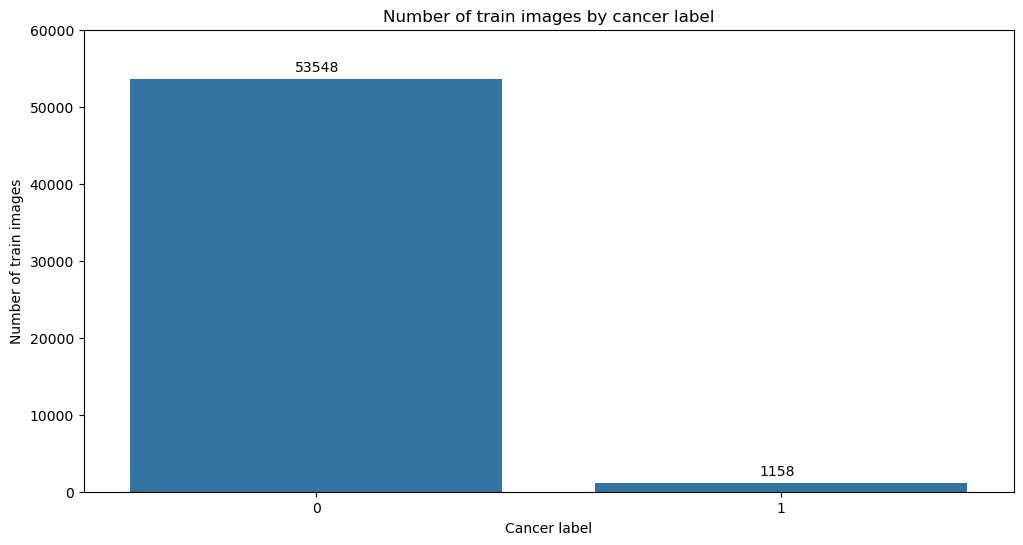

In [5]:
# Number of train images by cancer label
ax = sns.countplot(
    data=metadata_train, 
    x="cancer",
    order=metadata_train["cancer"].value_counts().index,
    color=pal[0]
)

for p, label in zip(ax.patches, metadata_train["cancer"].value_counts()):
    ax.annotate(label, (p.get_x() + 0.354, p.get_height() + 1000.15))

plt.title("Number of train images by cancer label")
plt.xlabel("Cancer label")
plt.ylabel("Number of train images")
plt.ylim([0, 60000])
plt.show()

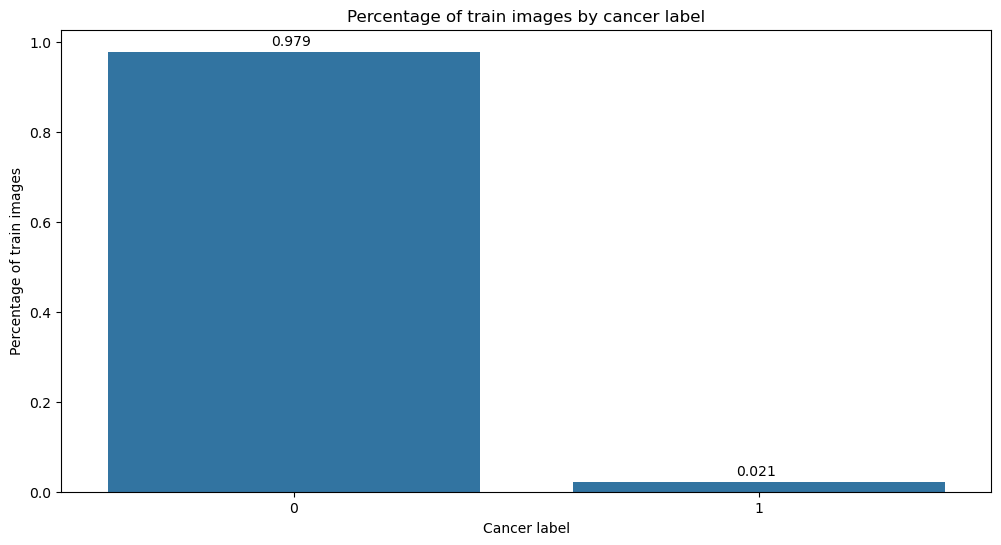

In [6]:
# Percentage of train images by cancer label
ax = sns.barplot(
    data=pd.DataFrame(metadata_train["cancer"].value_counts(normalize=True)) \
        .reset_index() \
        .rename(columns={"cancer": "pct", "index": "cancer"}),
    x="cancer",
    y="pct",
    order=metadata_train["cancer"].value_counts().index,
    color=pal[0]
)

for p, label in zip(ax.patches, round(metadata_train["cancer"].value_counts(normalize=True), 3)):
    ax.annotate(label, (p.get_x() + 0.35, p.get_height() + 0.015))
    
plt.title("Percentage of train images by cancer label")
plt.xlabel("Cancer label")
plt.ylabel("Percentage of train images")
plt.show()

Highly imbalanced data as expected. Resilience to false negatives will be important.

#### Patient ID

In [7]:
# Print number of unique patient IDs
print(f"There are {metadata_train['patient_id'].nunique()} unique patient IDs")

There are 11913 unique patient IDs


In [8]:
# Summary stats number of records per patient
print(f"{'-'*100}\nSummary stats for number of records per patient\n{'-'*100}")
print(metadata_train["patient_id"].value_counts().describe())

----------------------------------------------------------------------------------------------------
Summary stats for number of records per patient
----------------------------------------------------------------------------------------------------
count    11913.000000
mean         4.592126
std          1.133216
min          4.000000
25%          4.000000
50%          4.000000
75%          5.000000
max         14.000000
Name: patient_id, dtype: float64


An average of 4-5 train images per patient, with a max number of train images for patients being 14. We should pay attention to patient ID when conducting cross validation, splitting using patient ID as a group to avoid data leakage. 

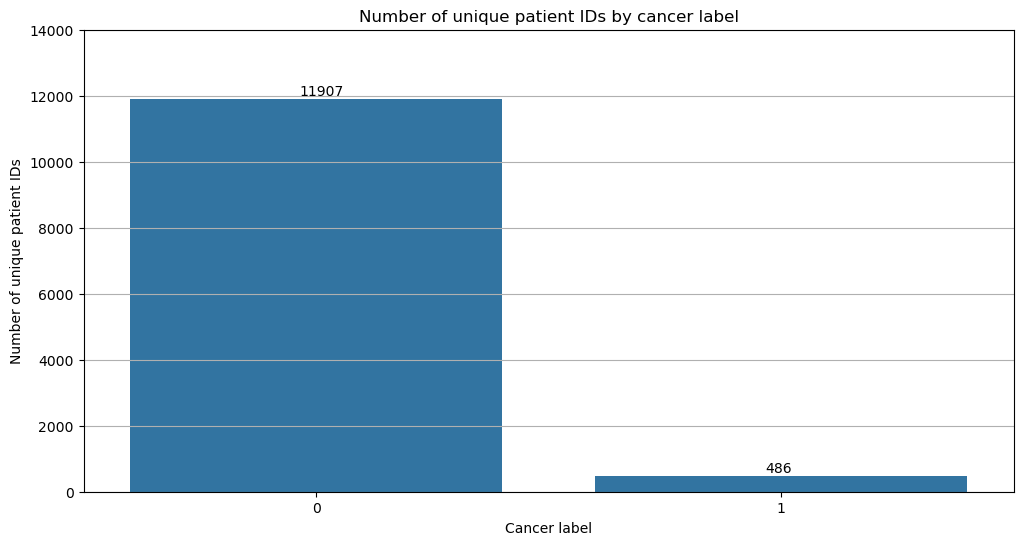

In [9]:
# Number of unique patients by cancer label
ax = sns.barplot(
    data=pd.DataFrame(metadata_train.groupby(["cancer"])["patient_id"].nunique()).reset_index(),
    x="cancer",
    y="patient_id",
    color=pal[0]
)

for p, label in zip(ax.patches, metadata_train.groupby(["cancer"])["patient_id"].nunique()):
    ax.annotate(label, (p.get_x() + 0.365, p.get_height() + 100))

plt.title("Number of unique patient IDs by cancer label")
plt.xlabel("Cancer label")
plt.ylabel("Number of unique patient IDs")
plt.ylim([0, 14000])
plt.grid(axis="y")
plt.show()

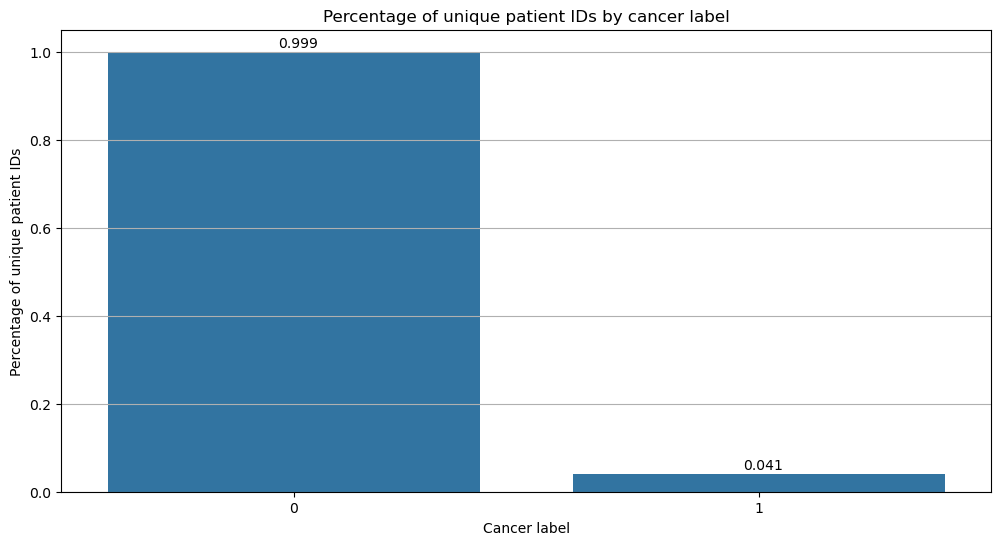

In [10]:
# Percentage of unique patients by cancer label
ax = sns.barplot(
    data=(pd.DataFrame(
        metadata_train.groupby(["cancer"])["patient_id"].nunique()
    ) / metadata_train["patient_id"].nunique()).reset_index(),
    x="cancer",
    y="patient_id",
    color=pal[0]
)

for p, label in zip(ax.patches, round(metadata_train.groupby(["cancer"])["patient_id"].nunique() \
                                 / metadata_train["patient_id"].nunique(), 3 )):
    ax.annotate(label, (p.get_x() + 0.365, p.get_height() + 0.01))

plt.title("Percentage of unique patient IDs by cancer label")
plt.xlabel("Cancer label")
plt.ylabel("Percentage of unique patient IDs")
plt.grid(axis="y")
plt.show()

0.99 and 0.041 don't add up to 100%, so there are obviously some patients with both cancer and non-cancer images (either through historical images or if imaging is conducted on both breasts but the cancer diagnosis exists in one breast) 

In [11]:
# Summary stats number of unique cancer values per patient
print(f"{'-'*100}\nSummary stats for number of unique cancer values per patient\n{'-'*100}")
print(metadata_train.groupby(["patient_id"])["cancer"].nunique().describe())
print(f"\n{'-'*100}\nNumber of unique cancer values by patient totalled\n{'-'*100}")
print(metadata_train.groupby(["patient_id"])["cancer"].nunique().value_counts())

----------------------------------------------------------------------------------------------------
Summary stats for number of unique cancer values per patient
----------------------------------------------------------------------------------------------------
count    11913.000000
mean         1.040292
std          0.196652
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          2.000000
Name: cancer, dtype: float64

----------------------------------------------------------------------------------------------------
Number of unique cancer values by patient totalled
----------------------------------------------------------------------------------------------------
1    11433
2      480
Name: cancer, dtype: int64


On average most patients have one unique cancer diagnosis. 

#### Site ID

In [12]:
# Print unique site IDs
print(f"There are {metadata_train['site_id'].nunique()} unique site IDs")
print(f"Site IDs: {metadata_train['site_id'].unique()}")

There are 2 unique site IDs
Site IDs: [2 1]


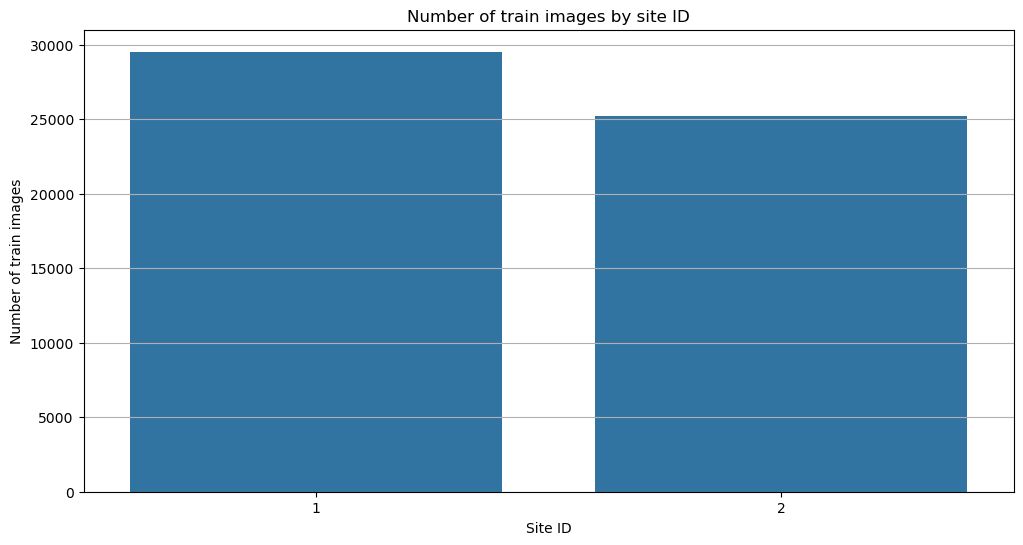

In [13]:
# Number of train images by site ID
sns.barplot(
    data=pd.DataFrame(metadata_train["site_id"].value_counts()) \
        .reset_index() \
        .rename(columns={"site_id": "pct", "index": "site_id"}),
    x="site_id",
    y="pct",
    color=pal[0]
)
    
plt.title("Number of train images by site ID")
plt.xlabel("Site ID")
plt.ylabel("Number of train images")
plt.grid(axis="y")
plt.show()

Number of train records by site ID seems to be split down the middle.

In [14]:
# Percentage of confirmed cancer images by site ID
print(
f"{'-'*100}\nPct of cancer positive images for each site ID (of total number of train \
cancer positive images)\n{'-'*100}"
)
print(metadata_train.groupby("site_id")["cancer"].sum() / metadata_train["cancer"].sum())

----------------------------------------------------------------------------------------------------
Pct of cancer positive images for each site ID (of total number of train cancer positive images)
----------------------------------------------------------------------------------------------------
site_id
1    0.573402
2    0.426598
Name: cancer, dtype: float64


Site 1 has the majority of cancer positive images out of the total number of cancer positive images in the train set, but not by a huge amount.

In [15]:
# Percentage of confirmed cancer images by site ID
print(f"{'-'*100}\nPercentage of cancer positive images (of number of train images) by site ID\n{'-'*100}")
print(metadata_train.groupby("site_id")["cancer"].sum() / metadata_train["site_id"].value_counts())

----------------------------------------------------------------------------------------------------
Percentage of cancer positive images (of number of train images) by site ID
----------------------------------------------------------------------------------------------------
site_id
1    0.022494
2    0.019613
dtype: float64


Site 1 has a slightly higher percentage of cancer positive images out of the number of images for each site ID compared to site 2, but these are more equal (presumably because site 1 in general has a slightly higher number of train images).

In [16]:
# Number of unique patients by site ID
print(f"{'-'*100}\nNumber of unique patient IDs by site ID\n{'-'*100}")
print(metadata_train.groupby("site_id")["patient_id"].nunique())

----------------------------------------------------------------------------------------------------
Number of unique patient IDs by site ID
----------------------------------------------------------------------------------------------------
site_id
1    5818
2    6095
Name: patient_id, dtype: int64


Site ID is pretty much split down the middle in terms of how many unique patients have had imaging completed there.

In [17]:
# Number of unique site IDs by patient ID
print(f"{'-'*100}\nSummary stats for number of unique site IDs by patient ID\n{'-'*100}")
print(metadata_train.groupby("patient_id")["site_id"].nunique().describe())

----------------------------------------------------------------------------------------------------
Summary stats for number of unique site IDs by patient ID
----------------------------------------------------------------------------------------------------
count    11913.0
mean         1.0
std          0.0
min          1.0
25%          1.0
50%          1.0
75%          1.0
max          1.0
Name: site_id, dtype: float64


No patient has had imaging done in both site IDs, based on the unique patient IDs. Site ID therefore seems to be not helpful, unless there are differences in imaging techniques. If there are visible differences in imaging for site IDs, we'll have to consider this during cross validation. Let's look into that later.

#### Laterality

In [18]:
# Print unique laterality
print(f"There are {metadata_train['laterality'].nunique()} unique laterality values")
print(f"Laterality values: {metadata_train['laterality'].unique()}")

There are 2 unique laterality values
Laterality values: ['L' 'R']


In [19]:
# Summary stats for number of unique laterality values per patient
print(f"{'-'*100}\nSummary stats for number of unique laterality values per patient ID\n{'-'*100}")
print(metadata_train.groupby('patient_id')['laterality'].nunique().describe())

----------------------------------------------------------------------------------------------------
Summary stats for number of unique laterality values per patient ID
----------------------------------------------------------------------------------------------------
count    11913.0
mean         2.0
std          0.0
min          2.0
25%          2.0
50%          2.0
75%          2.0
max          2.0
Name: laterality, dtype: float64


In [20]:
# Number of train images by laterality
print(f"{'-'*100}\nNumber of train images by laterality\n{'-'*100}")
print(metadata_train["laterality"].value_counts())

----------------------------------------------------------------------------------------------------
Number of train images by laterality
----------------------------------------------------------------------------------------------------
R    27439
L    27267
Name: laterality, dtype: int64


The number of train images are pretty much exactly the same for each laterality value. This makes sense as I can't imagine that imaging is frequently done for one breast and not the other. 

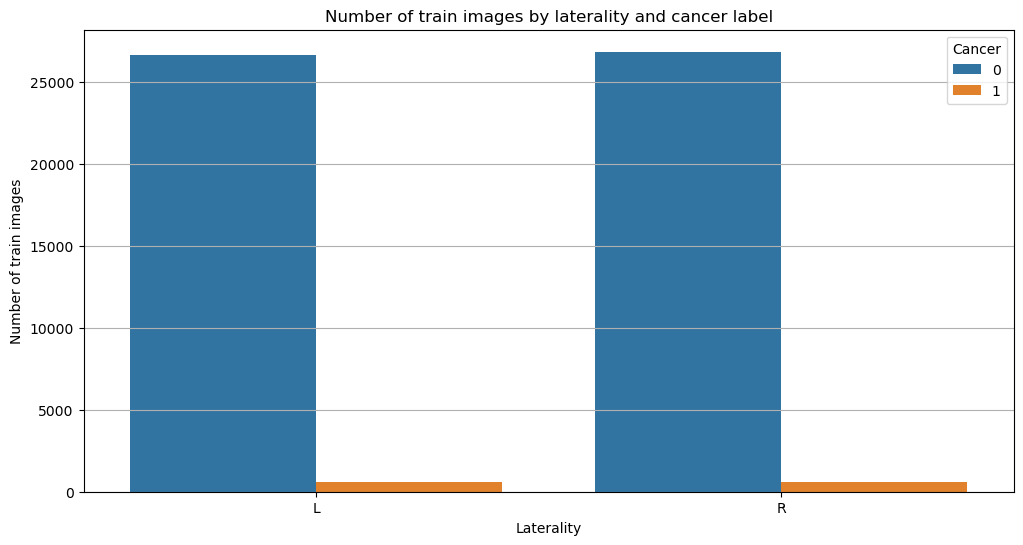

In [21]:
# Number of train images by cancer label and laterality
ax = sns.barplot(
    data=pd.DataFrame(metadata_train.groupby(["laterality", "cancer"])["patient_id"].count()).reset_index(),
    x="laterality",
    y="patient_id",
    hue="cancer"
)
    
plt.title("Number of train images by laterality and cancer label")
plt.xlabel("Laterality")
plt.ylabel("Number of train images")
plt.legend(loc="upper right", title="Cancer")
plt.grid(axis="y")
plt.show()

The number of cancer positive images seem consistent across laterality. 

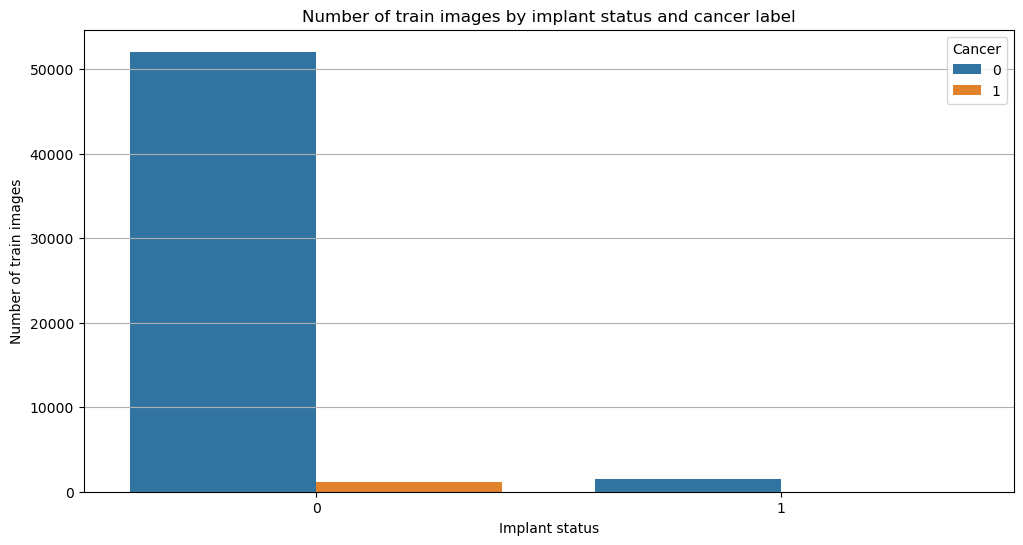

In [24]:
# Number of train images by cancer label and implant status
ax = sns.barplot(
    data=pd.DataFrame(metadata_train.groupby(["implant", "cancer"])["patient_id"].count()).reset_index(),
    x="implant",
    y="patient_id",
    hue="cancer"
)
    
plt.title("Number of train images by implant status and cancer label")
plt.xlabel("Implant status")
plt.ylabel("Number of train images")
plt.legend(loc="upper right", title="Cancer")
plt.grid(axis="y")
plt.show()

#### View

In [25]:
# Number of unique view values
print(f"There are {metadata_train['view'].nunique()} unique view values")

There are 6 unique view values


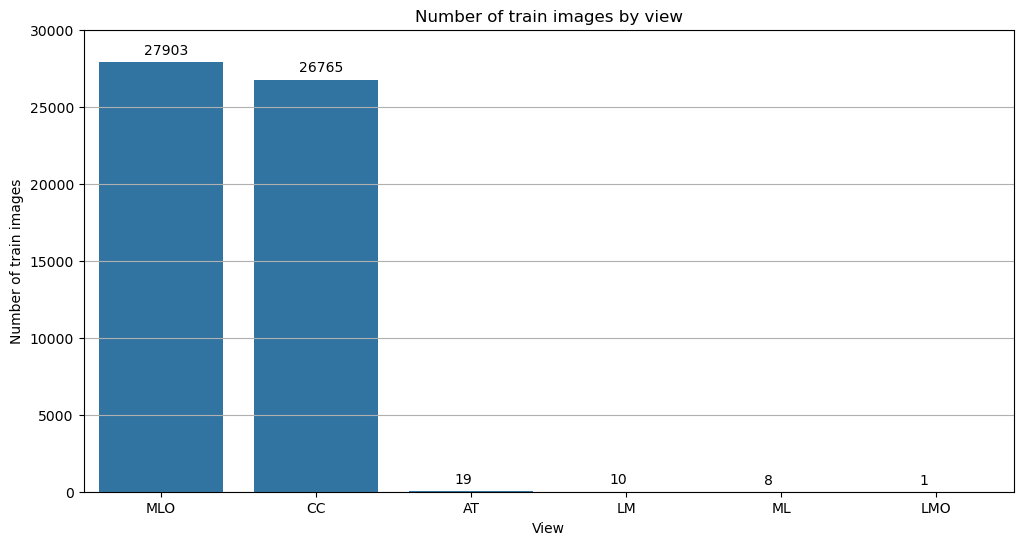

In [26]:
# Number of train images by cancer label
ax = sns.countplot(
    data=metadata_train, 
    x="view",
    order=metadata_train["view"].value_counts().index,
    color=pal[0]
)

for p, label in zip(ax.patches, metadata_train["view"].value_counts()):
    ax.annotate(label, (p.get_x() + 0.29, p.get_height() + 500.15))

plt.title("Number of train images by view")
plt.xlabel("View")
plt.ylabel("Number of train images")
plt.ylim([0, 30000])
plt.grid(axis="y")
plt.show()

The majority of scans come from the `MLO` and `CC` views, this is expected. Other views `AT`, `LM`, `ML` and `LMO` amount to 38 train images together.

`MLO` (mediolateral oblique)

It is likely that `LM` is the same as `ML` and `LMO` is the same as `MLO` - we should be able to make these changes given the small numbers.

Taken from the web:
        
*The `ML` view loses significant tissue volume in the upper outer quadrant of the breast where statistically the most breast cancers are found. By doing an `MLO` view you get extra tissue without extra exposure. The downside of the `MLO` view is it is not 90 degrees to the `CC` view so localisation of a lesion requires some thought.*

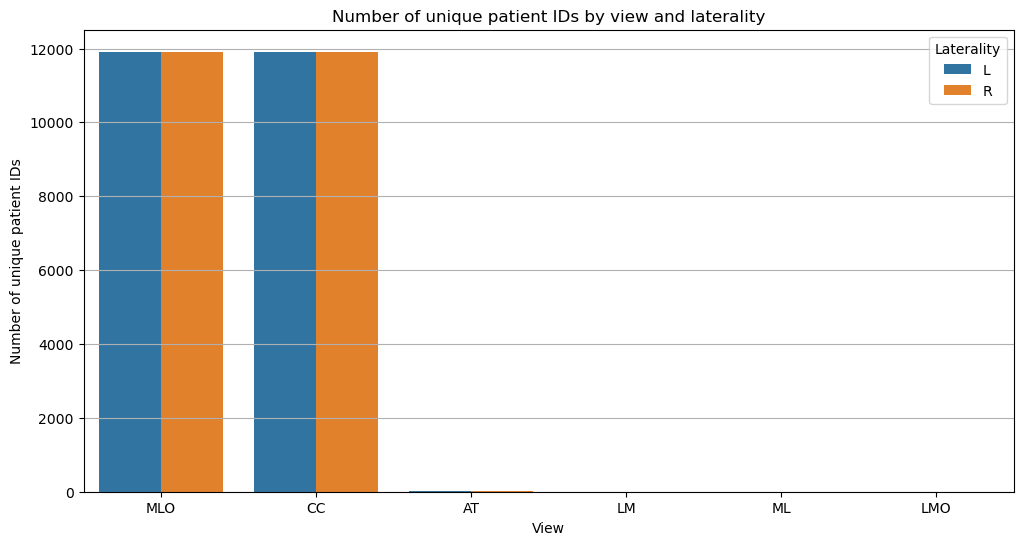

In [27]:
# Number of unique patients by view and laterality
ax = sns.barplot(
    data=pd.DataFrame(metadata_train.groupby(["view", "laterality"])["patient_id"].nunique()).reset_index(),
    x="view",
    y="patient_id",
    hue="laterality",
    order=metadata_train["view"].value_counts().index
)
    
plt.title("Number of unique patient IDs by view and laterality")
plt.xlabel("View")
plt.ylabel("Number of unique patient IDs")
plt.legend(loc="upper right", title="Laterality")
plt.grid(axis="y")
plt.show()

View continues to appear to be a not very useful feature, based on the metadata, in terms of predicting cancer status. This will need to be checked against the images themselves, like for site ID.

#### Machine ID

In [28]:
# Print unique machine_id
print(f"There are {metadata_train['machine_id'].nunique()} unique machine IDs")

There are 10 unique machine IDs


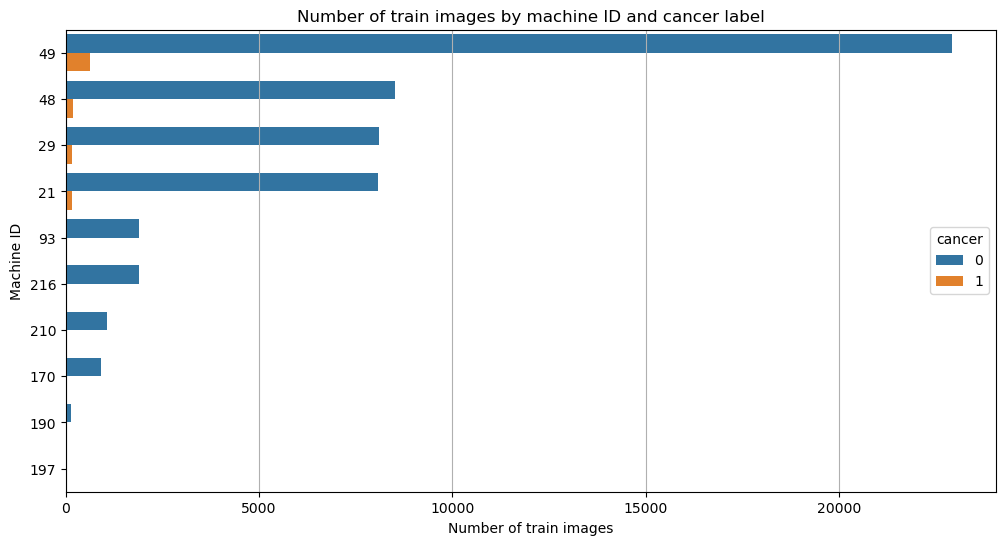

In [29]:
# Number of train images by machine ID and cancer label
ax = sns.countplot(
    data=metadata_train, 
    y="machine_id",
    order=metadata_train["machine_id"].value_counts().index,
    hue="cancer"
)

plt.title("Number of train images by machine ID and cancer label")
plt.xlabel("Number of train images")
plt.ylabel("Machine ID")
plt.grid(axis="x")
plt.show()

There's quite a large variance for number of train images by machine ID. We should definitely assess the difference in imaging for each machine ID, as we want to make sure there is no data leakage.

#### Implant

In [30]:
# Number of train images by implant status
print(f"{'-'*100}\nNumber of train images by implant status\n{'-'*100}")
print(metadata_train['implant'].value_counts())

----------------------------------------------------------------------------------------------------
Number of train images by implant status
----------------------------------------------------------------------------------------------------
0    53229
1     1477
Name: implant, dtype: int64


In [31]:
# Number of cancer positive images by implant status
print(f"{'-'*100}\nNumber of cancer positive train images by implant status\n{'-'*100}")
print(metadata_train.groupby(['implant'])['cancer'].sum())

----------------------------------------------------------------------------------------------------
Number of cancer positive train images by implant status
----------------------------------------------------------------------------------------------------
implant
0    1145
1      13
Name: cancer, dtype: int64


There are very few train images with a positive implant status. This may be more important information alongside images, as images may have subtle differences that are not neccessarily relevant to cancer status.

We don't have the `difficult_negative_case` flag for test data, so we won't be able to use this in testing. But it would be interesting to know if implant status has a noticable impact on the `difficult_negative_case` flag. 

In [32]:
# Fisher exact test for implant and difficult_negative_case
print(f"{'-'*100}\nFisher's exact test for implant and difficult_negative_case\n{'-'*100}")
print(f"\n{pd.crosstab(index=metadata_train['implant'], columns=metadata_train['difficult_negative_case'])}\n")
odd_ratio, p_value = stats.fisher_exact(
    pd.crosstab(index=metadata_train["implant"], columns=metadata_train["difficult_negative_case"])
)
print(f"Odds ratio: {odd_ratio}")
print(f"P value: {p_value}")

----------------------------------------------------------------------------------------------------
Fisher's exact test for implant and difficult_negative_case
----------------------------------------------------------------------------------------------------

difficult_negative_case  False  True
implant                             
0                        45797  7432
1                         1204   273

Odds ratio: 1.3972286717400555
P value: 2.0359213009586076e-06


If our null hypothesis is that there is *no association* between implant status and whether the image was a difficult negative case. Our alternative hypothesis is that there *is an association* between implant status and whether the image was a difficult negative case.

We successfully reject the null hypothesis based on the above (with high confidence) and accept the alternative hypothesis - there does seem to be an association between implant status and whether a case was a difficult negative.

In [33]:
# Fisher exact test for implant and cancer status
print(f"{'-'*100}\nFisher's exact test for implant and cancer status\n{'-'*100}")
print(f"\n{pd.crosstab(index=metadata_train['implant'], columns=metadata_train['cancer'])}\n")
odd_ratio, p_value = stats.fisher_exact(
    pd.crosstab(index=metadata_train["implant"], columns=metadata_train["cancer"])
)
print(f"Odds ratio: {odd_ratio}")
print(f"P value: {p_value}")

----------------------------------------------------------------------------------------------------
Fisher's exact test for implant and cancer status
----------------------------------------------------------------------------------------------------

cancer       0     1
implant             
0        52084  1145
1         1464    13

Odds ratio: 0.4039253585319875
P value: 0.0003138537845925493


Repeating a similar test to the above: if our null hypothesis is that there is *no association* between implant status and cancer status. Our alternative hypothesis is that there *is an association* between implant status and cancer status. 

In this test we reject the null hypothesis at the 0.0005 significance level (with a strong amount of confidence) and accept the alternative hypothesis - there is an association between implant status and cancer status. 

This is interesting - although numbers are small so can be volatile to tests like this. 

Overall tests done above should be taken with a pinch of salt. The test settings have not been prepared and would not be acceptable in scientific communities. But still, it's interesting to see the results.

#### Age

In [34]:
# Number of unique ages
print(f"There are {metadata_train.age.nunique()} unique ages.")
print(f"Ages range from {metadata_train.age.min()} to {metadata_train.age.max()}.")

There are 63 unique ages.
Ages range from 26.0 to 89.0.


In [35]:
# Summary stats for number of ages per patient
print(f"{'-'*100}\nNumber of recorded ages by patient ID\n{'-'*100}")
print(metadata_train[["patient_id", "age"]].drop_duplicates()["patient_id"].value_counts().describe())

----------------------------------------------------------------------------------------------------
Number of recorded ages by patient ID
----------------------------------------------------------------------------------------------------
count    11913.0
mean         1.0
std          0.0
min          1.0
25%          1.0
50%          1.0
75%          1.0
max          1.0
Name: patient_id, dtype: float64


There appear to be no patients who have recorded multiple ages during imaging, which is useful to know. This could have caused extra issues to handle going forward if not.

In [36]:
# Summary stats for number of patients per age
print(f"{'-'*100}\nSummary stats for number of patients per age\n{'-'*100}")
print(metadata_train.groupby(["age"])["patient_id"].nunique().describe())

----------------------------------------------------------------------------------------------------
Summary stats for number of patients per age
----------------------------------------------------------------------------------------------------
count     63.000000
mean     188.968254
std      169.386175
min        1.000000
25%       17.000000
50%      185.000000
75%      370.000000
max      505.000000
Name: patient_id, dtype: float64


On average, there are ~189 patients for each age in the dataset. The has a large std though, with a minimum of 1 patient for a particular age, and a maximum of 505 patients for a particular age. Age is therefore affected highly by numbers that exist in the dataset. 

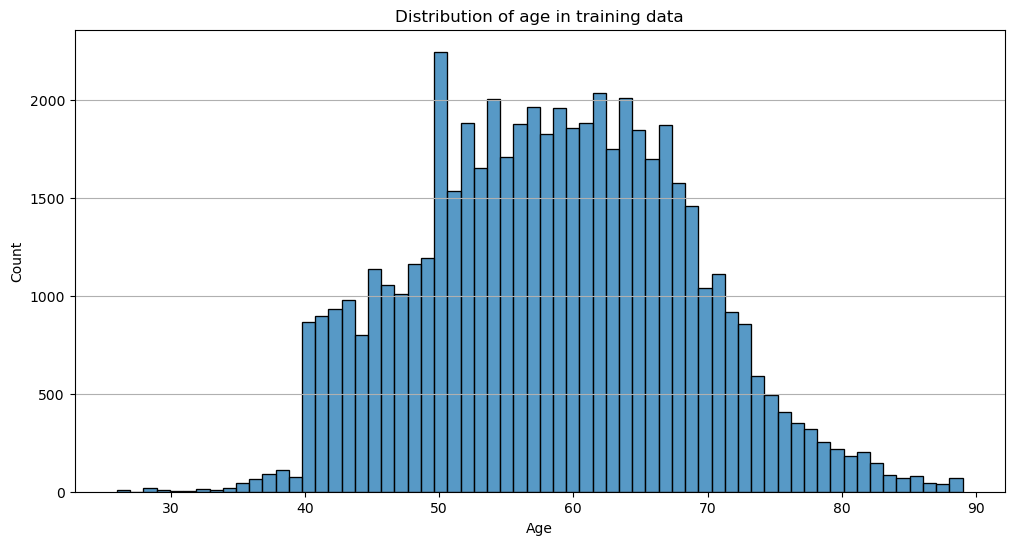

In [37]:
# Distribution of age
sns.histplot(
    data=metadata_train["age"],
    bins=64
)

plt.title("Distribution of age in training data")
plt.xlabel("Age")
plt.ylabel("Count")
plt.grid(axis="y")
plt.show()

The distribution of age is indicative of the typical age groups that will be tested for cancer, so there may be some data leakage in the age variable. Regardless, most patients are aged between 

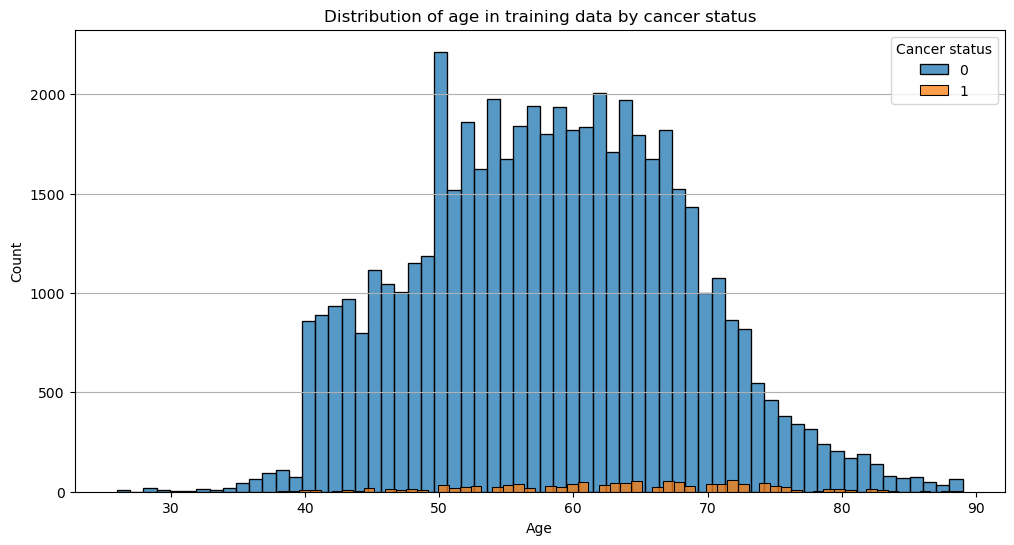

In [38]:
# Distribution of age by cancer status
sns.histplot(
    data=metadata_train.loc[metadata_train.cancer == 0, "age"],
    bins=64,
    color=pal[0],
)

sns.histplot(
    data=metadata_train.loc[metadata_train.cancer == 1, "age"],
    bins=64,
    color=pal[1],
)

plt.title("Distribution of age in training data by cancer status")
plt.xlabel("Age")
plt.ylabel("Count")
plt.grid(axis="y")
plt.legend([0, 1], title="Cancer status") # Manually set
plt.show()

Numbers are slightly too low to compare the distributions of age by cancer status on the same chart.

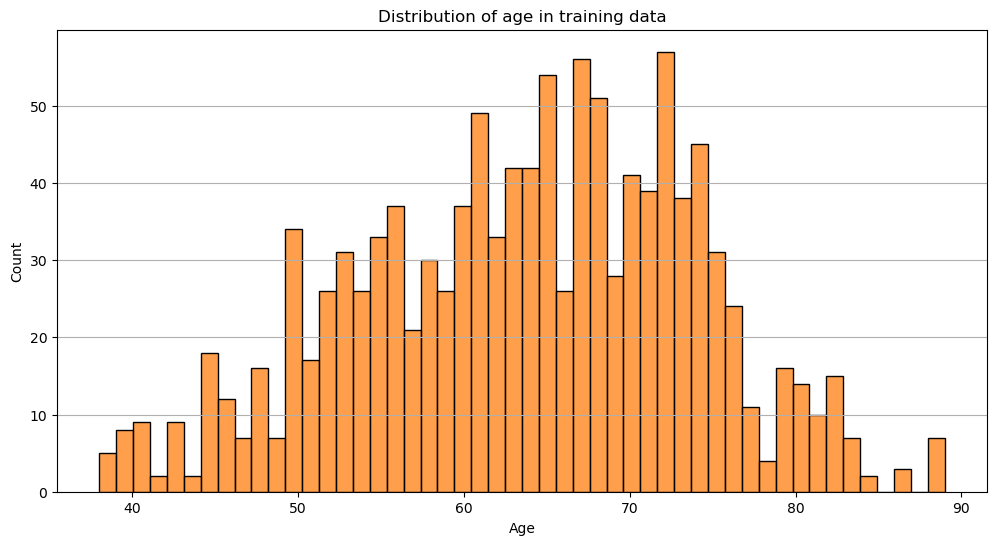

In [39]:
# Distribution of age by cancer status
sns.histplot(
    data=metadata_train.loc[metadata_train.cancer == 1, "age"],
    bins=50,
    color=pal[1],
)

plt.title("Distribution of age in training data")
plt.xlabel("Age")
plt.ylabel("Count")
plt.grid(axis="y")
plt.show()

It definitely appears that patients aged between 55 and 75 have the highest number of cancer positive images, however this could again be due to numbers getting checked in that age group. We should normalise that number of people for each age to get a better understanding.

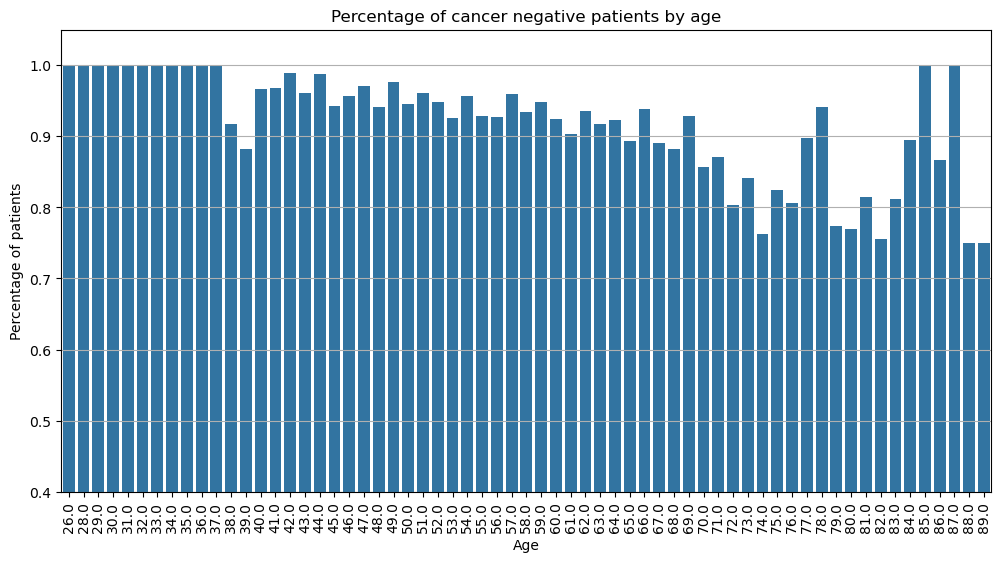

In [40]:
# Get unique patient cancer status and age df
patients_pos = metadata_train.loc[metadata_train.cancer == 1, "patient_id"].drop_duplicates()
ages = metadata_train[["patient_id", "age", "cancer"]].drop_duplicates()
# Get unique patient rows where cancer positive supercedes negative
ages_pos = ages.loc[~((ages.patient_id.isin(patients_pos)) & (ages.cancer == 0))]

# Get percentage of age that is cancer positive
ages_pos_group = ages_pos.groupby(["age", "cancer"])["patient_id"].count()
ages_total = ages.groupby("age")["patient_id"].count()
ages = pd.merge(
    pd.DataFrame(ages_pos_group).rename(columns={"patient_id": "cnt_patients"}).reset_index(), 
    pd.DataFrame(ages_total).rename(columns={"patient_id": "cnt_total"}).reset_index(), 
    on="age", 
    how="outer"
)
ages["pct_patients"] = ages["cnt_patients"] / ages["cnt_total"]

# Plot percentage of cancer patients by age
sns.barplot(
    data=ages.loc[ages.cancer == 0], 
    x="age", 
    y="pct_patients", 
    color=pal[0]
)

plt.title("Percentage of cancer negative patients by age")
plt.xlabel("Age")
plt.xticks(rotation=90)
plt.ylabel("Percentage of patients")
plt.ylim([0.4, 1.05])
plt.grid(axis="y")
plt.show()

The percentage of cancer negative patients for each age is 100% between ages 26 and 37, and begins to fluctuate from 38 upwards. There are two ages above 37 where there are 100% cancer negative patients (85 and 87). The percentage of cancer negative patients decreases from around the age of 60 upwards, with the lowest percentages of cancer negative patients being around late 70s and early 80s. 

Maybe there is an opportunity here to explore in modelling (data-focussed)? As a brainstorm, we could:

 - Exclude all patients belonging to ages where there are 100% cancer negative patients
 - In addition to the above, downsample all ages to match as closely as possible the lowest percentage of cancer negative patients (75% is the minimum).
 - Remove age as a metadata feature? 
 
There's potentially some more metadata analysis that we can do, particularly on the features that aren't included in the test data (`biopsy`, `invasive`, `BIRADS`, `density`). We might add this later as some more questions come up during modelling or further analysis.

## Image analysis

Things to look into:
 - Random line that goes through image (lots of padding too) E.g. PID 10006 IID 462822612
 - Text string in images E.g. PID 10706 IID 763186195
 - Different angles? Could make sure to rotate images during augs/training. Is the laterality the reason for different sides? Should we reflect so they're all the same side?
 - 

In [51]:
for patient in os.listdir(data_raw_train_dir_path)[0:2]:
    patient_path = os.path.join(data_raw_train_dir_path, patient)
    for img_name in os.listdir(patient_path):
        img_path = os.path.join(patient_path, img_name)
        
        ds = dicom.dcmread(img_path)
        img = ds.pixel_array
        
        print(img)

[[1803 1845 1874 ... 3044 3044 3044]
 [1834 1866 1902 ... 3044 3044 3044]
 [1866 1894 1903 ... 3044 3044 3044]
 ...
 [2250 2259 2240 ... 3044 3044 3044]
 [2246 2256 2235 ... 3044 3044 3044]
 [2196 2217 2226 ... 3044 3044 3044]]
[[3076 3076 3076 ... 1856 1838 1821]
 [3076 3076 3076 ... 1841 1838 1829]
 [3076 3076 3076 ... 1847 1842 1838]
 ...
 [3076 3076 3076 ... 2236 2222 2190]
 [3076 3076 3076 ... 2301 2301 2289]
 [3076 3076 3076 ... 2304 2297 2311]]
[[3044 3044 3044 ... 3044 3044 3044]
 [3044 3044 3044 ... 3044 3044 3044]
 [3044 3044 3044 ... 3044 3044 3044]
 ...
 [3044 3044 3044 ... 3044 3044 3044]
 [3044 3044 3044 ... 3044 3044 3044]
 [3044 3044 3044 ... 3044 3044 3044]]
[[3204 3204 3204 ... 3204 3204 3204]
 [3204 3204 3204 ... 3204 3204 3204]
 [3204 3204 3204 ... 3204 3204 3204]
 ...
 [3204 3204 3204 ... 3204 3204 3204]
 [3204 3204 3204 ... 3204 3204 3204]
 [3204 3204 3204 ... 3204 3204 3204]]
[[  0   0   0 ... 226 220 213]
 [  0   0   0 ... 212 220 211]
 [  0   0   0 ... 226 225 